# WHIPPOT Tutorial

Author: Jonathan Aguilar (jaguilar@stsci.edu)

This notebook provides a general user interface for computing the offset values required in APT to perform TA in some some target and the placing some *other* target on the reference position of the aperture. The user provides the RA and Dec coordinates for the target acquisition (ACQ) star and science (SCI) star, and a telescope roll angle. These tools will then compute a) the "Special Requirment Offset" X and Y values needed to place the SCI star at the reference position, and b) the final coordinates of the SCI and ACQ stars. Coordinates are given in IDL (https://jwst-docs.stsci.edu/jwst-observatory-hardware/jwst-target-observability-and-observatory-coordinate-system/jwst-instrument-ideal-coordinate-systems#gsc.tab=0). If there is no separate ACQ star (i.e., self-TA), or if TA is not involved, 

The user can also provide a list of extra targets in the field in the format specified below, and their IDL coordinates will also be computed. As such, this notebook is useful not just for planning target acquisition, but also for predicting to high precision the final positions of astronomical bodies in the field of view.

## Setup ##

- With installing the module:
  1. Navigate in a terminal to the directory where you have downloaded the module. This should contain the `setup.py` file.
  2. Activate your desired python environment.
  3. Run `pip install .` (if you plan to make your own modifications, use `pip install -e .`)
  4. Copy this notebook to your working directory, and run your jupyter kernel in the appropriate environment.
- Without installing the module:
  1. Copy this notebook and `whippot_tools.py` to your working directory.
  2. In the cell below, change `from whippot import whippot_tools` to `import whippot_tools`
  3. Open the notebook as you normally would. The following python modules must be installed in the working enviroment:
     -  `ipywidgets`
     - `numpy`
     - `matplotlib`
     - `astropy`
     - `pysiaf`


In [1]:
# for development purposes
%load_ext autoreload
%autoreload 2

In [2]:
# for your system, choose an appropriate plotting backend to make pop-up window plots
# (currently, inline plots show up in the log but not directly in the notebook).
# %matplotlib osx throws an error if you run it first, so do inline first.
%matplotlib inline
%matplotlib osx

In [3]:
from whippot import whippot_tools

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-068 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-071
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


## Usage

1. Run the cell below, which will generate an interactive widget in the output space.
2. Select your instrument and science aperture from the drop-down menus.
   - An "aperture" is a region of the telescope that can be used for pointing. This terminology is adapted from the Science Instrument Aperture File (SIAF)
     - This technical report is a useful, if incomplete, reference: https://www.stsci.edu/files/live/sites/www/files/home/jwst/documentation/technical-documents/_documents/JWST-STScI-007030.pdf
   - The science aperture names can be a bit opaque, but you should be able to guess which one corresponds to your observation.
   - If you have access to data that uses the subarray of interest, you can check the header for the "APERNAME" there and match it.
   - ¡¡Warning!! There are *many* choices for apertures and their names can be opaque. If in doubt, speak with someone familiar with your instrument and the SIAF.
4. Enter the RA and Dec coordinates of your acquisition and science targets.
   - the frame must be 'ICRS'
   - the units must be in decimal degrees
5. Enter the PA angle of the V3 axis of the telescope at the instrument reference point.
   - In APT, this corresponds to the "Specify PA range using V3PA" option under Special Requirements.
   - This angle is given in data headers as "ROLL_REF"
6. If you wish to know the positions of other stars in the field of view, you can enter them in the "Other stars" box
   - The format is `label: (ra, dec)` where `ra` and `dec` are given in decimal degrees
   - There is currently no error checking for formatting; you will just make it crash/get a wrong answer
   - For multi-line entries, you may need to type them elsewhere and they copy-paste the list into the box
7. Press "Compute offset" to get the offsets to enter into APT (you may need to press it twice).
   - You will also get the positions in IDL coordinates of all the stars before and after the slew.
   - For same-target TA, a hack is to enter the same position for the ACQ and SCI target. In the examples below that use an initialization dictionary, omitting `acq_ra` and `acq_dec` fields will cause this to be done automatically.


## Initialization with default values

Run the cell below to initialize the gui. 
- In the Instrument menu, select MIRI
- In the Aperture menu, select MIRIM_MASK1550 (the 15-um coronagraph)
- Set ACQ RA and Dec to (1.01, 0.99)
- Set SCI RA and Dec to (1, 1).
- Then, copy the lines below and paste them into the `Other stars` box, as an example:
```
a: (1.001, 1.002)
b: (1.002, 1.003)
c: (1.003, 1.004)
```

In [9]:
# create the ComputeOffsets object and start the UI with default initialization.
cp1 = whippot_tools.ComputePositions()
# to display the user interface, just do this:
cp1.ui
# Note: the footprint tools don't do a good job handling apertures that span RA = 0

Press "Compute positions" to get the coordinates of the targets. Then press "Plot scenes" to visualize them.

You can access the IDL coordinates from the object to use them programatically:

In [10]:
# This dictionary stores the coordinates *after* TA but *before* the slew to the reference position
cp1.idl_coords_after_ta

{'SCI': array([0., 0.])}

In [11]:
# This dictionary stores the coordinates *after* the slew to the reference position
cp1.idl_coords_after_slew

{'SCI': array([0., 0.])}

## Initialization from a configuration dictionary

Alternatively, one can provide a dictionary to pre-populate the fields of the interface. This is useful for repeatability/record keeping purposes. A non-empty dictionary will automatically trigger the output calculations, filling in default values for missing entries.

As an example, let's use MIRI's 15.5 um coronagraph to do TA on a star at (90, 45) and then slew to another star that is (50 arcsec, 50 arcsec) away, with the telescope oriented at a V3_PA angle of 180 deg. There are two other stars of interest, labeled a and b, located at separations (-10 arcsec, +10 arcsec), and (+10 arcsec, -10 arcsec), respectively, from the SCI star

**<span style="color:red">WARNING</span>**: for each set of calculations, create a new "ComputeOffsets" object. Calling the same UI object again changes its values globally.

In [12]:
from astropy import units
ACQ_pos = (90.0, 45)
# the SCI target is ~(50, 50) arcsec away (50 arcsec ->. 0.0139 deg)
SCI_pos = (90 + 0.014, 45 + 0.014)
# the field stars are ~(-10, +10) and (+10, -10) arcsec away from the SCI star (10 arcsec -> 0.0028 deg)
a_pos = (SCI_pos[0] - 0.003, SCI_pos[1] + 0.003)
b_pos = (SCI_pos[0] + 0.003, SCI_pos[1] - 0.003)

# populate the initialization dict with these values

initial_values={
    'instr': 'miri',
    'sci_aper': 'mirim_coron1550', 
    'pa': 180.,
    'acq_ra': ACQ_pos[0], 'acq_dec': ACQ_pos[1],
    'sci_ra': SCI_pos[0], 'sci_dec': SCI_pos[1]
}
# add a multi-line string of the other stars
initial_values['other_stars'] = f"""
a: ({a_pos[0]}, {a_pos[1]})
b: ({b_pos[0]}, {b_pos[1]})
"""

In [13]:
cp2 = whippot_tools.ComputePositions(initial_values=initial_values)
cp2.ui

# Placing your target at the position of another star in the field

This is useful for the case where you need to generate an off-axis reference PSF for a star in the field of view. Compute the IDL position of the star in the science scene, and the *negative* of that star's IDL positition to the `Offset X` and `Offset Y` values. For example, to place the target at the position of star `a = (-11.3071, -10.2835)`, you would enter the following Offset X and Y values.

In the example below, we enter the `a` star's IDL position to the "Final IDL X/Y" fields, leaving everything else the same. This is equivalent to saying, "At the end of all the TA, I want `a` to be at these coordinates.". The "Offset X/Y" output will give the offsets required to place the target star at the position of `a`, which you will see in the confirmation plot.

In [14]:
# first, update the initialization dict with the offsets
with_offset = {
    'final_idl_x': cp2.idl_coords_after_slew['a'][0],
    'final_idl_y': cp2.idl_coords_after_slew['a'][1]
}
# copy over the rest of the initial_values dictionary to the with_offset dictionary
with_offset.update(initial_values)

cp3 = whippot_tools.ComputePositions(initial_values=with_offset)
cp3.ui

Compare the positions of the scene before and after the extra slew. You can see that the SCI target is now where 'a' was.

In [15]:
fig, ax = whippot_tools.plt.subplots(1, 1)
ax.set_title("Placing SCI where A used to be")
ax.scatter([],[], marker='x', c='k', label='Before')
ax.scatter([],[], marker='+', c='k', s=100, label='After')
for star in cp2.idl_coords_after_slew.keys():
    l = ax.scatter(
        *cp2.idl_coords_after_slew[star],
        marker='x', label=star,
        zorder=-1
    )
    ax.scatter(
        *cp3.idl_coords_after_slew[star],
        marker='+', facecolor=l.get_facecolor(),
        zorder=1, s=100,
    )
cp3.get_aper().plot(ax=ax, frame='idl', mark_ref=True, c='gray', fill=False)
ax.legend()

## Running without the GUI

The positions and plots can be generated directly from a script using the ComputePositions methods `compute_positions()` and `plot_scene()`. 

Computing parameters can be set by modifying entries in the `parameter_values` dictionary. 

In [16]:
cp4 = whippot_tools.ComputePositions(initial_values)
cp4.compute_positions()

In [17]:
cp4.idl_coords_after_slew

{'ACQ': array([31.25404394, 53.22705259]),
 'SCI': array([0., 0.]),
 'a': array([  8.5194679 , -10.11668748]),
 'b': array([-8.52023948, 10.1163389 ])}

In [18]:
# adjust the PA by 5 degrees
cp4.parameter_values['pa'] = cp4.parameter_values['pa'] + 5

In [19]:
# we're setting the parameter dictionary directly, so don't read the widget state
cp4.compute_positions(update_params_from_widgets=False)
cp4.idl_coords_after_slew

{'ACQ': array([26.49606114, 55.74847108]),
 'SCI': array([0., 0.]),
 'a': array([ 9.36877897, -9.33567069]),
 'b': array([-9.3695171 ,  9.33525621])}

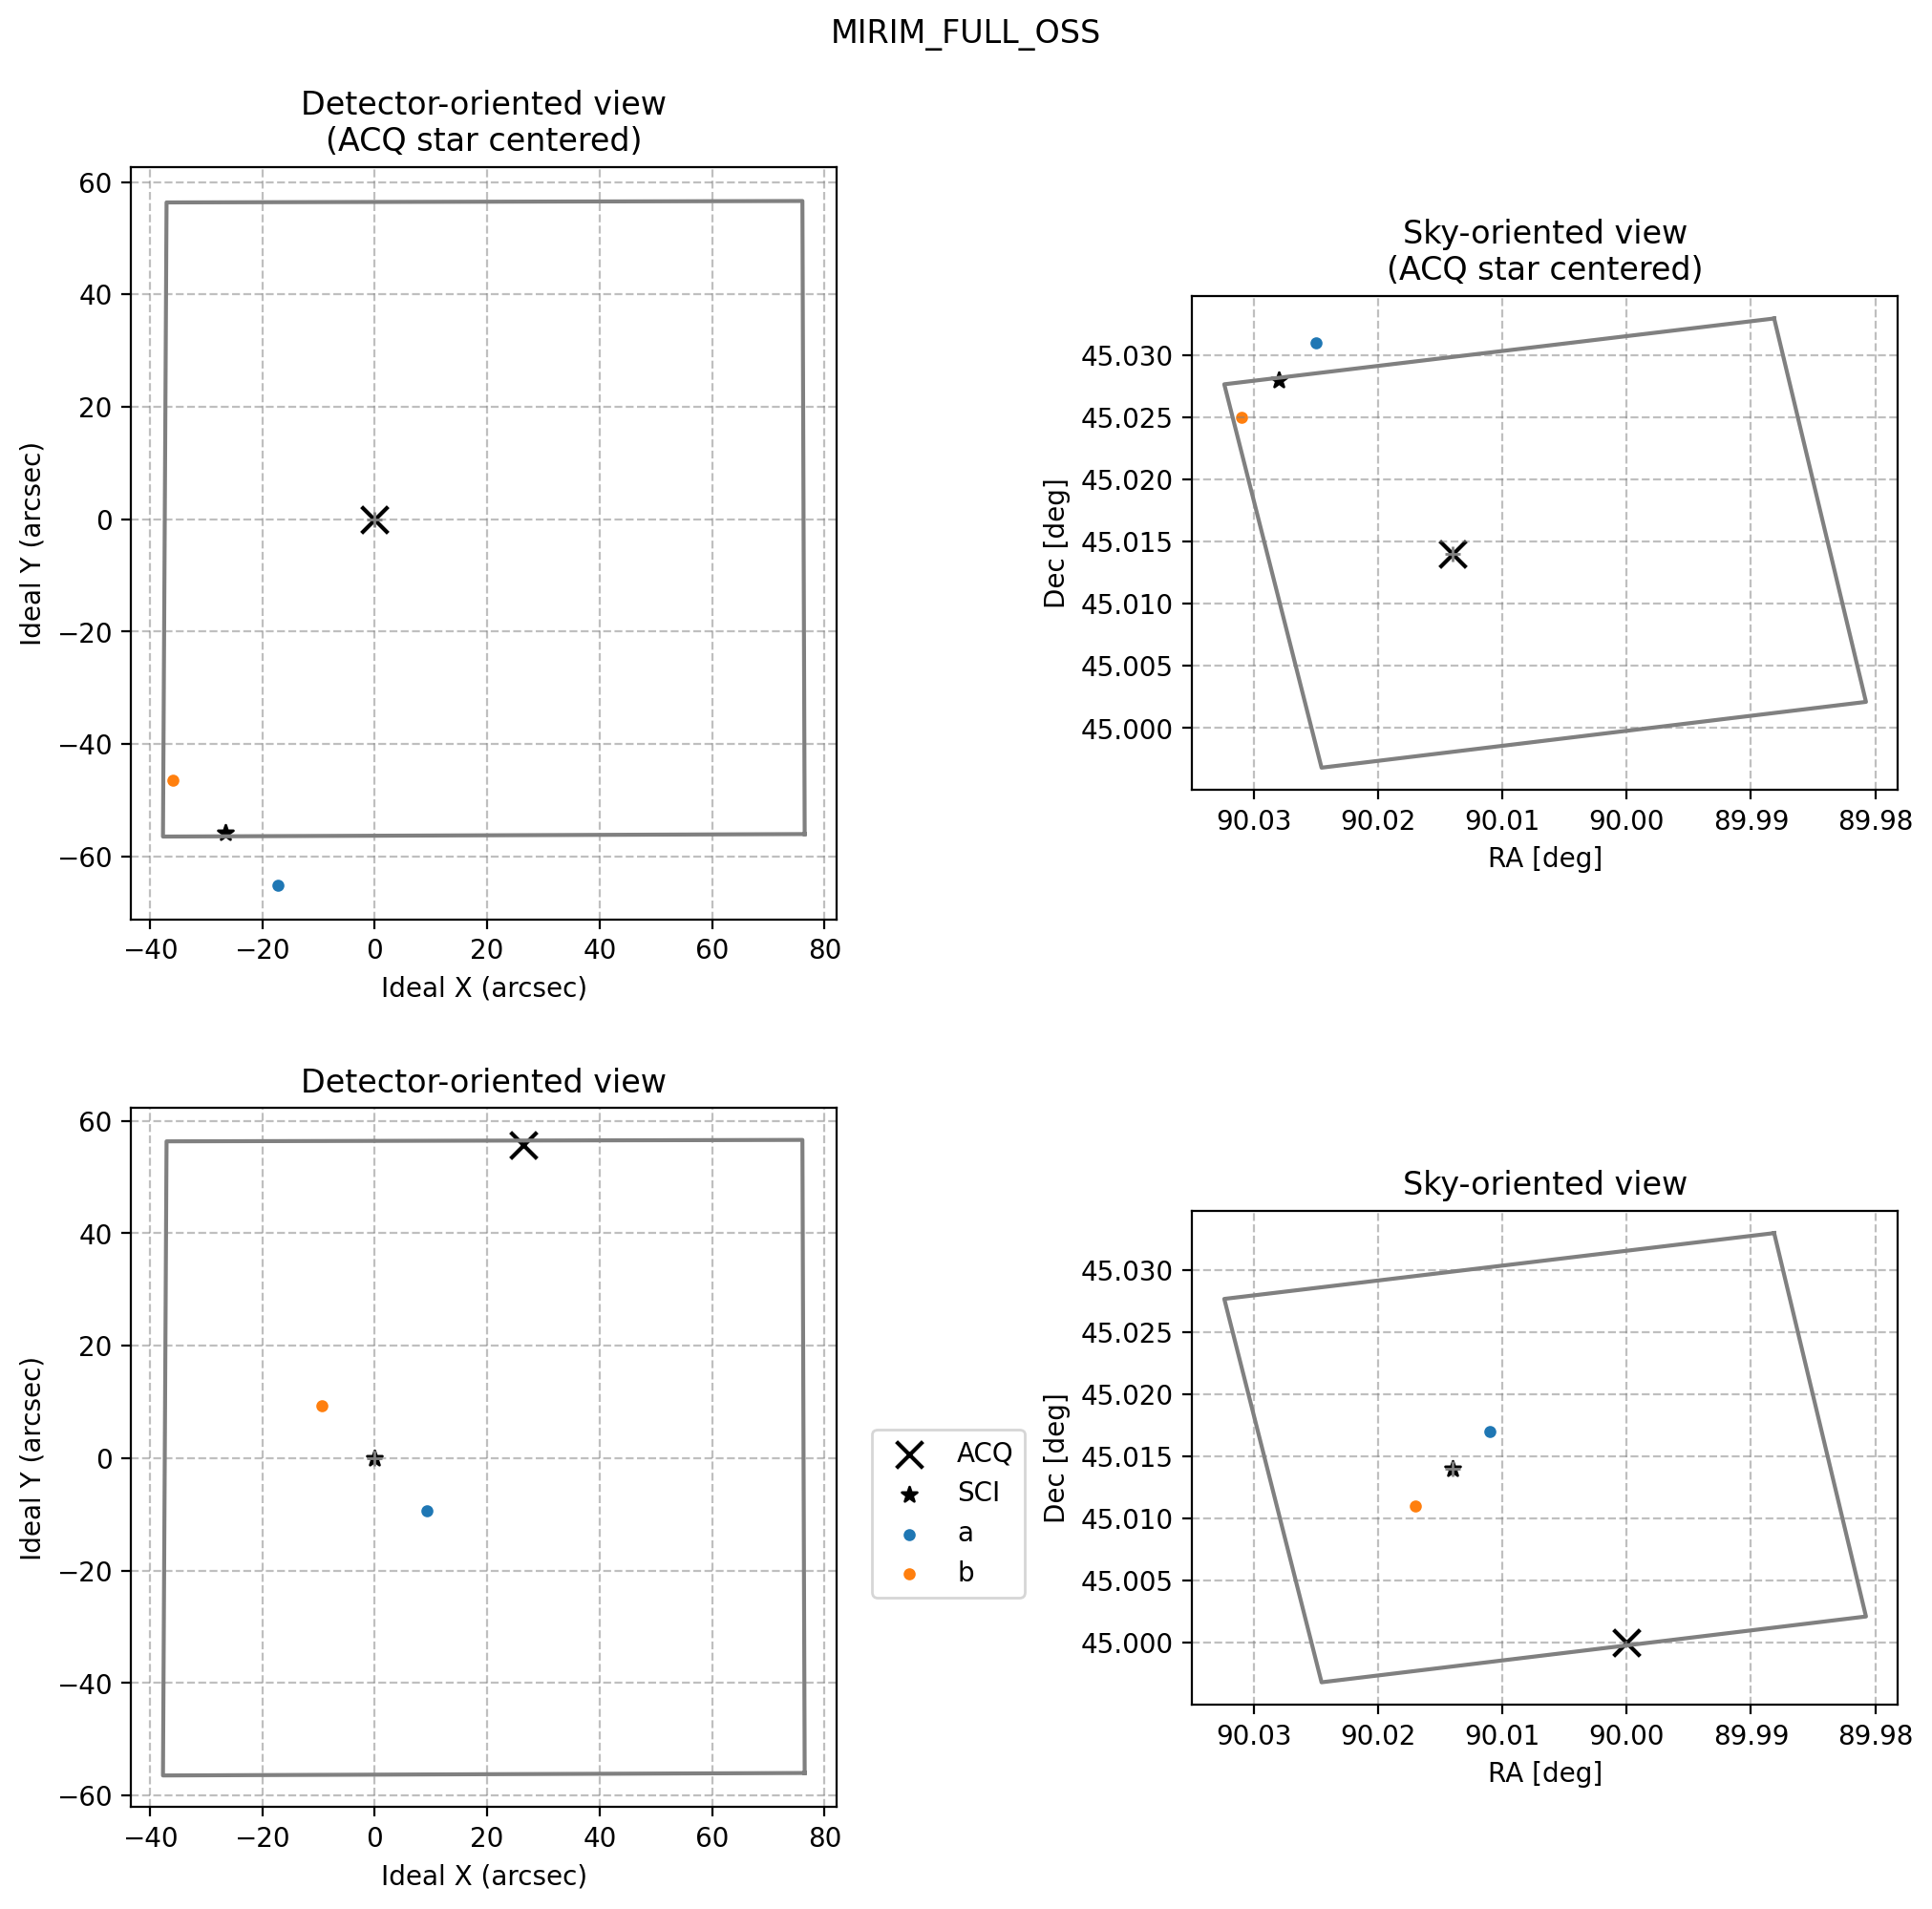

In [20]:
fig = cp4.plot_scene()

## Extending functionality

The `whippot_tools.ComputePositions()` class will work for any aperture on the telescope, but only conveys a minimum of information. The `modes` folder contains mode-specific modules that can be tailored to each observing mode - generally, for adding extra information to the plots such as coronagraphic masks or spectral traces. Typically this is done by subclassing `whippot_tools.ComputePositions` and wrapping the `plot_scenes()` method. In this way, the usage remains the same.

An example: In `miri_lrs_slitless_tools.py`, we have extended the scene plots to show the spectral traces when using LRS Slitless spectroscopy.

In [21]:
from whippot.modes import miri_lrs_slitless_tools as mlst

In [22]:
# update the initialization dictionary to set the new aperture and remove the ACQ star (LRS slitless doesn't use TA)
lrs_init = initial_values.copy()
lrs_init.update({'acq_ra': lrs_init['sci_ra'], 'acq_dec': lrs_init['sci_dec']})
lrs_init['sci_aper'] = 'mirim_slitlessprism'

cp5 = mlst.ComputePositions(lrs_init)
cp5.ui